# 1. Data Imports and setting environment

**Project:** Predicting ventilator requirements for COVID‑19 (Target: `INTUBATED`)  
**Notebook:** `02_baseline_model.ipynb` (Baseline model)  

> **Goal:** Train and evaluate a transparent baseline model, establish reference metrics (F1, recall, precision, PR‑AUC), and save artefacts to `notebooks/outputs/`.


In [8]:
# ---------------------------------------------------------------------
# 1.1 Imports
# ---------------------------------------------------------------------

import os
from pathlib import Path
import json
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [ ]:
# ---------------------------------------------------------------------
# 1.2 Reproducibility + paths
# ---------------------------------------------------------------------
SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_DATA_PATH = OUTPUT_DIR / "covid_clean.parquet"   # produced by 01_eda.ipynb
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CLEAN_DATA_PATH:", CLEAN_DATA_PATH)


# 2.0 Load Clean Dataset

**Assumption:** `01_eda.ipynb` has already been run and produced `notebooks/outputs/covid_clean.parquet`.


In [10]:
# ---------------------------------------------------------------------
# 2.1 Load cleaned data
# ---------------------------------------------------------------------
if not CLEAN_DATA_PATH.exists():
    raise FileNotFoundError(
        f"Missing cleaned dataset at {CLEAN_DATA_PATH}. "
        "Run 01_eda.ipynb first (or update CLEAN_DATA_PATH)."
    )

df = pd.read_parquet(CLEAN_DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (192706, 22)


,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,intubated
0,0,1,0,0,09/06/2020,1,0,55,97,1,2,2,2,2,2,2,2,2,2,3,2,1
1,0,1,1,0,9999-99-99,0,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2,0
2,0,1,1,0,9999-99-99,0,0,37,2,1,2,2,2,1,2,2,1,2,2,3,2,0
3,0,1,1,0,9999-99-99,0,0,25,2,2,2,2,2,2,2,2,2,2,2,3,2,0
4,0,1,0,0,9999-99-99,0,0,24,97,2,2,2,2,2,2,2,2,2,2,3,2,0


In [11]:
# ---------------------------------------------------------------------
# 2.2 Identify target + features
# ---------------------------------------------------------------------
TARGET = "intubated"
if TARGET not in df.columns:
    raise KeyError(f"Expected target column '{TARGET}' not found. Columns: {list(df.columns)[:30]} ...")

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int).copy()

print("X shape:", X.shape)
print("y positive rate:", (y == 1).mean())


X shape: (192706, 21)
y positive rate: 0.174649466025967


# 3.0 Train/Test Split

We use a stratified split to preserve the class distribution (important for imbalanced medical outcomes).


In [12]:
# ---------------------------------------------------------------------
# 3.1 Stratified split
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train size:", X_train.shape, " Positive rate:", (y_train==1).mean())
print("Test size :", X_test.shape,  " Positive rate:", (y_test==1).mean())


Train size: (154164, 21)  Positive rate: 0.17465166965050205
Test size : (38542, 21)  Positive rate: 0.17464065175652535


# 4.0 Baseline Model

### Baseline choice
We use a **simple gradient boosted tree baseline** (XGBoost if available; otherwise a scikit‑learn fallback).

- Handles non‑linear interactions well for tabular clinical data
- Provides a strong reference point before adding advanced feature engineering or resampling

### Preprocessing
- Numeric: median imputation
- Categorical (if present): most frequent imputation + one‑hot encoding


In [13]:
# ---------------------------------------------------------------------
# 4.1 Column types
# ---------------------------------------------------------------------
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 20
Categorical features: 1


In [14]:
# ---------------------------------------------------------------------
# 4.2 Preprocessing pipeline
# ---------------------------------------------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)


In [15]:
# ---------------------------------------------------------------------
# 4.3 Baseline model definition
# ---------------------------------------------------------------------
# We try XGBoost first (consistent with later modelling), otherwise use a sklearn fallback.

def get_model():
    try:
        from xgboost import XGBClassifier

        # scale_pos_weight helps with imbalance
        pos = (y_train == 1).sum()
        neg = (y_train == 0).sum()
        spw = float(neg / max(pos, 1))

        model = XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            min_child_weight=1.0,
            gamma=0.0,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=SEED,
            n_jobs=-1,
            scale_pos_weight=spw
        )
        model_name = "XGBoost (baseline)"
        return model, model_name, {"scale_pos_weight": spw}

    except Exception as e:
        from sklearn.ensemble import HistGradientBoostingClassifier

        model = HistGradientBoostingClassifier(
            max_depth=4,
            learning_rate=0.05,
            max_iter=300,
            random_state=SEED
        )
        model_name = "HistGradientBoosting (fallback baseline)"
        return model, model_name, {"note": f"XGBoost unavailable: {type(e).__name__}"}

model, model_name, model_meta = get_model()
print("Model:", model_name)
print("Meta :", model_meta)


Model: XGBoost (baseline)
Meta : {'scale_pos_weight': 4.725682451253482}


In [16]:
# ---------------------------------------------------------------------
# 4.4 Fit pipeline
# ---------------------------------------------------------------------
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)
print("Fitted:", model_name)


Fitted: XGBoost (baseline)


# 5.0 Baseline Evaluation

We report:
- **F1-score** (balance between precision and recall)
- **Recall (sensitivity)** (minimise missed critical cases)
- **Precision** (minimise false alarms)
- **PR‑AUC** (robust summary for imbalanced classification)


In [17]:
# ---------------------------------------------------------------------
# 5.1 Predict + compute metrics
# ---------------------------------------------------------------------
y_pred = clf.predict(X_test)

# Some models provide predict_proba; use it for PR-AUC if available
y_proba = None
if hasattr(clf.named_steps["model"], "predict_proba"):
    y_proba = clf.predict_proba(X_test)[:, 1]

metrics = {
    "model": model_name,
    "f1": float(f1_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred)),
    "pr_auc": float(average_precision_score(y_test, y_proba)) if y_proba is not None else None,
    "n_train": int(len(y_train)),
    "n_test": int(len(y_test)),
    "positive_rate_train": float((y_train == 1).mean()),
    "positive_rate_test": float((y_test == 1).mean()),
}

metrics


{'model': 'XGBoost (baseline)',
 'f1': 1.0,
 'recall': 1.0,
 'precision': 1.0,
 'pr_auc': 1.0,
 'n_train': 154164,
 'n_test': 38542,
 'positive_rate_train': 0.17465166965050205,
 'positive_rate_test': 0.17464065175652535}

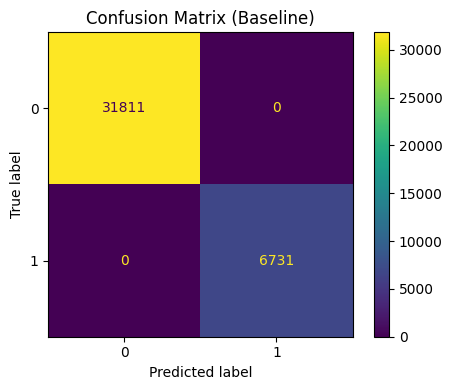

Saved: /Users/creer/Desktop/covid-ventilator-prediction-xgboost:/outputs/figures/baseline_confusion_matrix.png


In [18]:
# ---------------------------------------------------------------------
# 5.2 Confusion matrix
# ---------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix (Baseline)")
plt.tight_layout()
fig_path = FIG_DIR / "baseline_confusion_matrix.png"
plt.savefig(fig_path, dpi=200)
plt.show()

print("Saved:", fig_path)


***Summary of Baseline***

- The baseline provides a reference point for subsequent improvements (feature engineering, resampling, and hyperparameter optimisation).
- For imbalanced outcomes, **PR‑AUC** and **recall** are particularly informative.
- Next steps typically include: (i) engineered clinical severity features, (ii) SMOTE or class weighting comparisons, and (iii) cross‑validated tuning.


# 6.0 Save Baseline Artefacts

We save:
- Baseline metrics (`baseline_metrics.json` and `baseline_metrics.csv`)
- Confusion matrix figure (already saved)
- Fitted pipeline (`baseline_model.pkl`) for reuse


In [ ]:
# ---------------------------------------------------------------------
# 6.1 Save metrics + model
# ---------------------------------------------------------------------
import joblib

metrics_path_json = OUTPUT_DIR / "baseline_metrics.json"
metrics_path_csv  = OUTPUT_DIR / "baseline_metrics.csv"
model_path        = OUTPUT_DIR / "baseline_model.pkl"

with open(metrics_path_json, "w") as f:
    json.dump(
        {
            "seed": SEED,
            **metrics,
            "model_meta": model_meta,
        },
        f,
        indent=2
    )

pd.DataFrame([metrics]).to_csv(metrics_path_csv, index=False)
joblib.dump(clf, model_path)

print("Saved:", metrics_path_json)
print("Saved:", metrics_path_csv)
print("Saved:", model_path)
